## Instalação da biblioteca DETECTRON2 ##

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-gbqv5b71
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-gbqv5b71
  Resolved https://github.com/facebookresearch/detectron2.git to commit e70b9229d77aa39d85f8fa5266e6ea658e92eed3
  Preparing metadata (setup.py) ... done


## Importação das bibliotecas e funções ##

In [2]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

## Instalação da biblioteca do dataset e do próprio dataset ##

O dataset utilizado nesse Notebook foi obtido por meio do Site Roboflow. Site que possui uma diversidade de datasets.
A célula abaixo faz a importação de um dataset exemplo utilizado pela equipe do Detectron. Em caso de uso do próprio dataset,
você deve fazer a importação correta dos dados e dividi-los em treino, teste e validação, além de ter os arquivos de anotação em cada pasta.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="QL7VElr3am2bTh7OR53z")
project = rf.workspace("roboflow-jvuqo").project("football-pitch-segmentation")
dataset = project.version(1).download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...


## Regristrando a rede

In [4]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

## Definindo Arquivos de Traino, Teste e Validação

In [5]:
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

Verificar a nomeclatura dos arquivos

In [6]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['Dogs_Cats-train', 'Dogs_Cats-test', 'Dogs_Cats-valid']

Apenas uma vizualização de uma imagem do dataset com marcação e classificação

In [ ]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[2]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata,
    scale=0.8,
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])

## Treinando o Modelo utilizando o formato do Dataset customizado COCO 

### Configuração do modelo

In [8]:
# HYPERPARAMETERS

# ARCHITECTURE = "mask_rcnn_R_101_FPN_3x"
# ARCHITECTURE = "faster_rcnn_X_101_32x8d_FPN_3x"
ARCHITECTURE = "faster_rcnn_R_101_FPN_3x"

# CONFIG_FILE_PATH = f"COCO-InstanceSegmentation/{ARCHITECTURE}.yaml"
CONFIG_FILE_PATH = f"COCO-Detection/{ARCHITECTURE}.yaml"

MAX_ITER = 2000
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 3

OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME,
    ARCHITECTURE,
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [9]:
cfg = get_cfg() #criação de um objeto
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH)) # mescla a configuração do arquivo com o objeto
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH) # Define os pesos pré-treinado do modelo
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,) # Conjunto que será usado para treinamento
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,) # Conjunto que será usado para teste
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64 # Quantidade de regiões de interesse processadas por lote
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD # Periodo em que o modelo será avaliado
cfg.DATALOADER.NUM_WORKERS = 2 # Processos em parelelo
cfg.SOLVER.IMS_PER_BATCH = 2 # Número de imagens por lote para treinamento
cfg.INPUT.MASK_FORMAT= None # Em caso de uso de máscara
cfg.SOLVER.BASE_LR = BASE_LR # Taxa de aprendizado base
cfg.SOLVER.MAX_ITER = MAX_ITER # Itereações de treinamento
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES # Número de classes c/ o Background
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH # Diretório que o modelo será salvo

### Iniciar o treinamento

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

### Avaliação

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[02/05 14:19:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Dogs_Cats/faster_rcnn_R_101_FPN_3x/2024-02-05-14-02-45/model_final.pth ...


### Testar com as imagens de validação

In [ ]:
dataset_valid = DatasetCatalog.get(VALID_DATA_SET_NAME)

for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

## Teste com imagens individuais

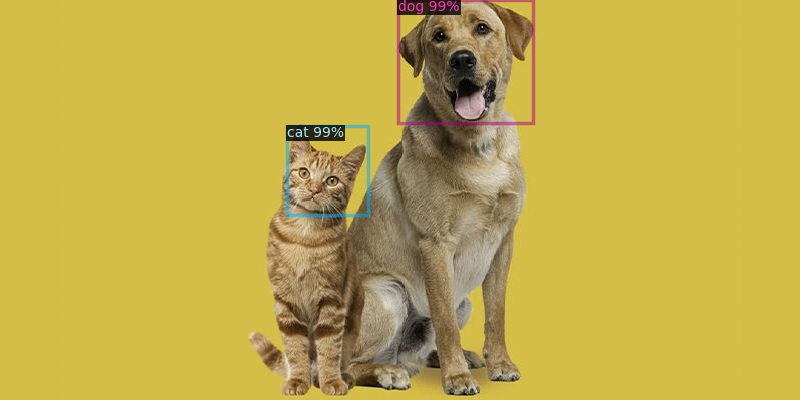

In [18]:
new_im = cv2.imread("/content/as-diferencas-entre-criar-um-cachorro-e-um-gato-041130.jpg")
outputs = predictor(new_im)

v = Visualizer(new_im[:, :, ::-1],metadata=metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

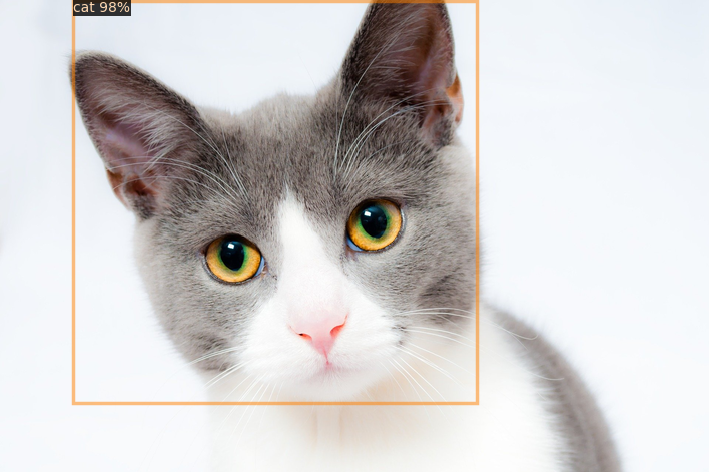

In [16]:
new_im = cv2.imread("/content/caracteristicas-do-gato-1-1.png")
outputs = predictor(new_im)

v = Visualizer(new_im[:, :, ::-1],metadata=metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

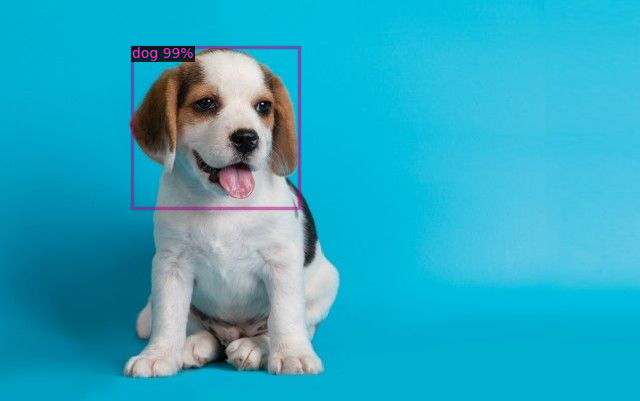

In [17]:
new_im = cv2.imread("/content/cuidados-filhote-de-cachorro (1).jpg")
outputs = predictor(new_im)

v = Visualizer(new_im[:, :, ::-1],metadata=metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])